In [1]:
from airsenal.framework.utils import *
from airsenal.framework.bpl_interface import get_fitted_team_model
from airsenal.framework.season import get_current_season, CURRENT_TEAMS

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax.numpy as jnp

%matplotlib inline

In [2]:
model_team = get_fitted_team_model(get_current_season(), NEXT_GAMEWEEK, session)

Fitting team model...


sample: 100%|██████████| 1500/1500 [00:13<00:00, 110.98it/s, 63 steps of size 7.55e-02. acc. prob=0.91]


No model for BRE


In [14]:
# extract indices of current premier league teams
# val-1 because 1-indexed in model but 0-indexed in python
current_idx = {team: idx for idx, team in enumerate(model_team.teams)
               if team in CURRENT_TEAMS}

top6 = ['MCI', 'LIV', 'TOT', 'CHE', 'MUN', 'ARS']

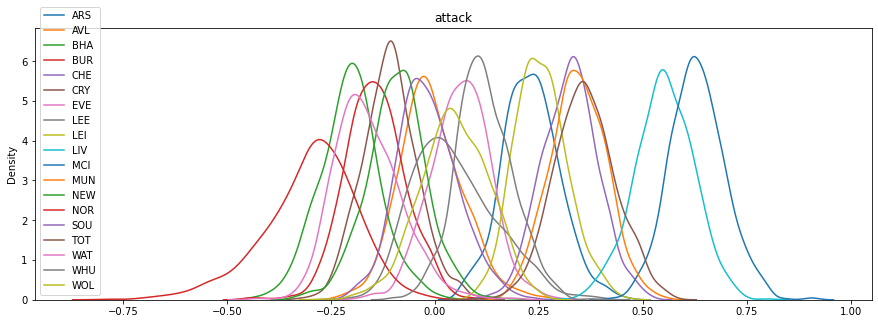

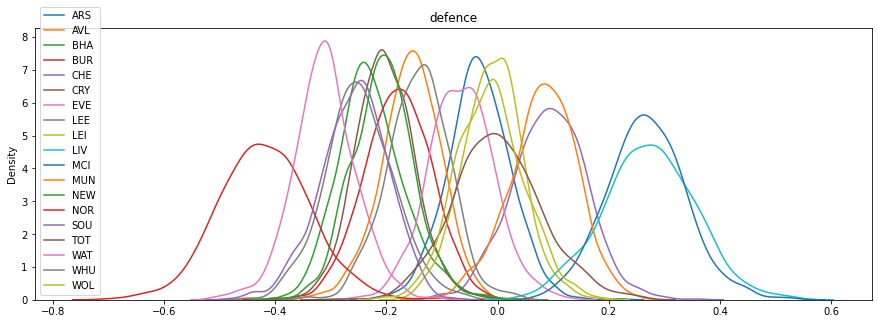

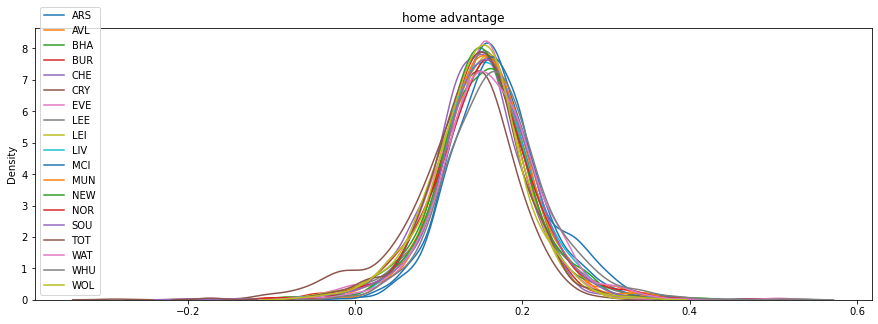

In [15]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.attack[:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.defence[:, idx], label=team)
plt.title('defence')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.kdeplot(model_team.home_advantage[:, idx], label=team)
plt.title('home advantage')
plt.legend()

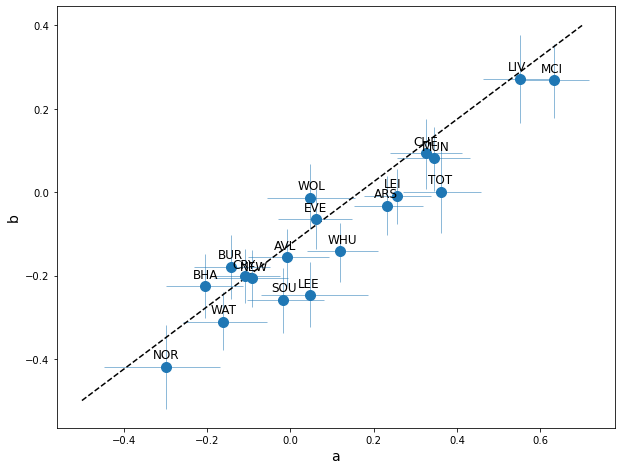

In [33]:
a_mean = model_team.attack.mean(axis=0)
b_mean = model_team.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(model_team.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(model_team.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(model_team.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(model_team.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = jnp.array(list(current_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('a', fontsize=14)
plt.ylabel('b', fontsize=14)

for team, idx in current_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)
    
plt.plot([-0.5,  0.7], [-0.5, 0.4], "k--")


Text(0.5, 1.0, 'Defence Coefficients (Covariates?)')

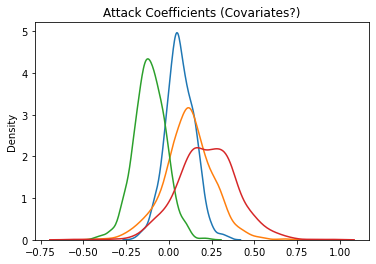

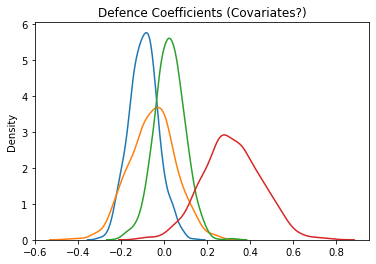

In [45]:
plt.figure()
for i in range(model_team.attack_coefficients.shape[1]):
    sns.kdeplot(model_team.attack_coefficients[:, i])
plt.title("Attack Coefficients (Covariates?)")

plt.figure()
for i in range(model_team.defence_coefficients.shape[1]):
    sns.kdeplot(model_team.defence_coefficients[:, i])
plt.title("Defence Coefficients (Covariates?)")

Text(0.5, 1.0, 'rho')

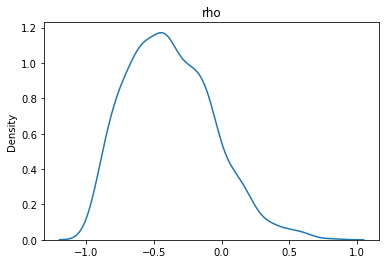

In [37]:
sns.kdeplot(model_team.rho)
plt.title("rho")

In [46]:
team_h = "MCI"
team_a = "MUN"

In [47]:
model_team.predict_concede_n_proba(2, team_h, team_a)

DeviceArray([0.19781268], dtype=float32)

In [48]:
model_team.predict_score_n_proba(2, team_h, team_a)

DeviceArray([0.26870385], dtype=float32)

In [49]:
model_team.predict_outcome_proba(team_h, team_a)

{'home_win': DeviceArray([0.5961007], dtype=float32),
 'away_win': DeviceArray([0.19012408], dtype=float32),
 'draw': DeviceArray([0.21377502], dtype=float32)}

In [50]:
model_team.predict_score_proba(team_h, team_a, 2, 2)

DeviceArray([0.05315302], dtype=float32)

MCI exp goals 2.0658808
MUN exp goals 1.0837476


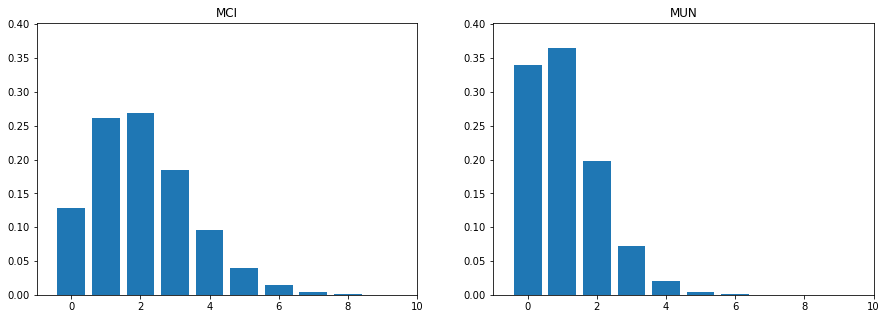

In [53]:
max_goals = 10

prob_score_h = [model_team.predict_score_n_proba(n, team_h, team_a)[0] for n in range(max_goals)]
print(team_h, "exp goals", sum([n*prob_score_h[n] for n in range(max_goals)])/sum(prob_score_h))

prob_score_a = [model_team.predict_score_n_proba(n, team_a, team_h, home=False)[0] for n in range(max_goals)]
print(team_a, "exp goals", sum([n*prob_score_a[n] for n in range(max_goals)])/sum(prob_score_a))

max_prob = 1.1*max(prob_score_h + prob_score_a)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(range(max_goals), prob_score_h)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_h)

plt.subplot(1,2,2)
plt.bar(range(max_goals), prob_score_a)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_a);

In [57]:
import numpyro
import numpyro.distributions as dist

mu = numpyro.sample('mu', dist.Normal(0, 5))

AssertionError: 

In [ ]:
model_team.log_score()

In [ ]:
model_team.plot_score_probabilities(team_h, team_a);

In [ ]:
sim = model_team.simulate_match(team_h, team_a)
sim[team_h].value_counts(normalize=True).sort_index().plot.bar()
plt.title(team_h)
plt.ylim([0, 0.4])
plt.xlim([-1, 8])

plt.figure()
sim[team_a].value_counts(normalize=True).sort_index().plot.bar()
plt.title(team_a)
plt.ylim([0, 0.4])
plt.xlim([-1, 8])

In [ ]:
df = model_team.simulate_match(team_h, team_a)
print(df.quantile(0.25))
print(df.median())
print(df.quantile(0.75))